In [1]:
import laspy 
import numpy as np
import os
from sklearn.neighbors import KDTree

folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches"

buffer_of_median_z_diff = []
buffer_of_mean_z_diff = []
buffer_of_z_diff = []
middle_points = []

for file in os.listdir(folder_path_20p):
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_5p = points_5p.prediction

    mask = predictions_5p != 1
    xyz_5p_filtered = xyz_5p[mask]

    splitcode_5p = points_5p[mask].splitcode


    if mask.sum() > 50:
        tree = KDTree(xyz_20p)
        dist, idx = tree.query(xyz_5p_filtered, k=1)

        for i in np.unique(splitcode_5p):
            # z_diff = xyz_20p[idx.flatten(), 2] - xyz_5p_filtered[:, 2]

            splitcode_mask = splitcode_5p == i
            xyz_5p_splitcode_filtered = xyz_5p_filtered[splitcode_mask]

            xyz_20p_filtered = xyz_20p[idx.flatten()]
            z_diff = xyz_20p_filtered[splitcode_mask, 2] - xyz_5p_splitcode_filtered[:, 2]

            buffer_of_z_diff.append(z_diff)
            buffer_of_median_z_diff.append(np.median(z_diff))
            buffer_of_mean_z_diff.append(np.mean(z_diff))

            center_xy = xyz_5p_splitcode_filtered[:, :2].mean(axis=0)
            middle_points.append(center_xy)


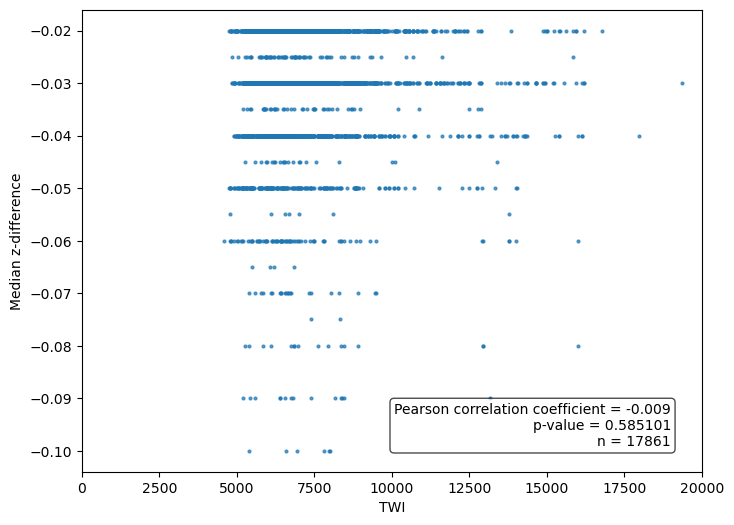

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform
from rasterio.transform import array_bounds
from shapely.geometry import Point
from rasterio.plot import show
import geopandas as gpd
from pyproj import Transformer
import scipy 

twi_16_path = r"C:\Users\telukkari\Documents\Data\wetness_index_16m2_2016\luke\twi\TWI_16m_Finland_NA_lakes_int.tif"

# Convert list of (x, y) tuples to NumPy array if not already
coords = np.array(middle_points)

with rasterio.open(twi_16_path) as src:
    # Sample all points at once
    values = [val[0] for val in src.sample(coords)]

twi_values = np.array(values)
buffer_of_median_z_diff = np.array(buffer_of_median_z_diff)
mask = (buffer_of_median_z_diff < -0.02) & (buffer_of_median_z_diff > -0.10)
masked_twi_values = twi_values[mask]
masked_coords = coords[mask]

middle_points_x = [point[0] for point in masked_coords]
middle_points_y = [point[1] for point in masked_coords]

masked_buffer_of_median_z_diff = buffer_of_median_z_diff[mask]

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    masked_twi_values,              
    masked_buffer_of_median_z_diff,              
    s=4,                           
    alpha=.7,
)

plt.xlabel("TWI")
plt.ylabel("Median z-difference")
plt.xlim([0, 20000])
# plt.ylim([-0.1, 0.0])

# Pearson correlation
pearson_r_value, p_value = scipy.stats.pearsonr(masked_twi_values, masked_buffer_of_median_z_diff)

n = len(twi_values)

# Add text to top-right corner
plt.text(
    0.95, 0.15,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.6f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.show()